# Real-Time Hand Gesture Recognition for Touchless Control

## Data Checking, Preprocessing and Visualization

### Inspecting the Dataset Structure 

This helps ensure that the dataset extracted correctly (i.e., no empty folders).

In [ ]:
import os

# Set the root directory where all video folders have been extracted.
# This path should contain subfolders named 1, 2, 3, etc. if we've correctly extracted Jester.
root_dir = "/tmp/20bn-jester-v1"

# Execute a shell command to list (in long format) the contents of root_dir,
# showing permissions, owners, sizes, and modification times for each file/folder.
!ls -l $root_dir

# Create a list of directory names in root_dir, filtering only those that are purely digits (e.g. "1", "2", "123").
# The condition d.isdigit() ensures we ignore any non-numeric directories or files.
all_dirs = [d for d in os.listdir(root_dir) if d.isdigit()]


In [2]:
%%bash
ls /tmp

ls -l /tmp/20bn-jester-v1 | head

20bn-jester-v1
tmphula9ovy
total 2369472
drwxrwxr-x. 2 1000 1000 16384 Jun  9  2017 1
drwxrwxr-x. 2 1000 1000 16384 Jun  9  2017 10
drwxrwxr-x. 2 1000 1000 16384 Jun  9  2017 100
drwxrwxr-x. 2 1000 1000 16384 Jun  9  2017 1000
drwxrwxr-x. 2 1000 1000 16384 Jun  9  2017 10000
drwxrwxr-x. 2 1000 1000 16384 Jun 10  2017 100000
drwxrwxr-x. 2 1000 1000 16384 Jun 10  2017 100001
drwxrwxr-x. 2 1000 1000 16384 Jun 10  2017 100002
drwxrwxr-x. 2 1000 1000 16384 Jun 10  2017 100003


In [3]:
# Initialize an empty list to store the frame count for each video
num_frames_per_video = []

# Loop over each video directory we identified
for video_id in all_dirs:
    # Build the full path to the folder containing this video's frames
    frames_path = os.path.join(root_dir, video_id)
    
    # List all files in that folder ending with '.jpg' (i.e., the frame images)
    frames = [f for f in os.listdir(frames_path) if f.endswith('.jpg')]
    
    # Append the number of frames in this directory to our list
    num_frames_per_video.append(len(frames))

In [4]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install opencv-python==4.11.0.86

In [6]:
!sudo apt-get update
!sudo apt-get install -y libgl1-mesa-glx


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease




libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 71 not upgraded.


In [7]:
!pip install nvidia-tensorrt # To use GPU

In [8]:
!pip install matplotlib

In [9]:
import random
import cv2
import matplotlib.pyplot as plt

### Checking & Handling Corrupt or Missing Data

Occasionally, a folder might have zero frames or a partially broken .jpg

BUT THIS TAKES TOO LONG

In [10]:
# problematic_videos = []  # We'll store IDs of videos with zero frames
# problematic_frames = []  # We'll store (video_id, frame_filename) for corrupt frames

# for video_id in all_dirs:
#     video_path = os.path.join(root_dir, video_id)
    
#     # Gather all .jpg files in this video's folder
#     frames_list = [f for f in os.listdir(video_path) if f.endswith('.jpg')]
    
#     # Check if the folder is empty (no frames)
#     if len(frames_list) == 0:
#         print(f"Warning: Video {video_id} has no frames!")
#         problematic_videos.append(video_id)
#         continue  # Move to the next video
    
#     # Attempt to read each frame with OpenCV
#     for frame_file in frames_list:
#         frame_path = os.path.join(video_path, frame_file)
#         img = cv2.imread(frame_path)
        
#         # If OpenCV fails to load the image, 'img' will be None
#         if img is None:
#             print(f"Corrupt frame in video {video_id}: {frame_file}")
#             problematic_frames.append((video_id, frame_file))

# # Summary
# print(f"\nFinished checking {len(all_dirs)} videos.")
# print(f"Videos with zero frames: {len(problematic_videos)}")
# print(f"Corrupt frames found: {len(problematic_frames)}")

In [11]:
print("Total videos:", len(num_frames_per_video))
print("Min frames in a video:", min(num_frames_per_video))
print("Max frames in a video:", max(num_frames_per_video))
print("Average frames:", sum(num_frames_per_video) / len(num_frames_per_video))

Total videos: 148092
Min frames in a video: 12
Max frames in a video: 70
Average frames: 35.65068335899306


### Basic Visualisation 

This helps verify the frames are 100px high (and variable width) and that the gesture is clearly visible.

In [12]:
# --- Randomly pick a video folder ---
# 1. We choose one folder (video) at random from our list 'all_dirs'.
# 2. Construct the absolute path to that folder, which contains all of the video's frames.
video_id = random.choice(all_dirs)
video_folder = os.path.join(root_dir, video_id)

In [13]:
# --- Gather the frame filenames for this video ---
# 1. List all files in 'video_folder' that end with '.jpg'.
# 2. Sort them to maintain chronological order (00001.jpg, 00002.jpg, etc.).
frames_list = sorted([f for f in os.listdir(video_folder) if f.endswith('.jpg')])

In [14]:
# --- Sample up to 5 frames (from start, middle, end, etc.) ---
# We create a list of indices for frames at meaningful positions:
#   - 0: the first frame
#   - len(frames_list)//3: approximately 1/3 through the video
#   - 2*len(frames_list)//3: about 2/3 through
#   - len(frames_list)-1: the last frame
frame_indices = [0, len(frames_list)//3, 2*len(frames_list)//3, len(frames_list)-1]

In [15]:
# We remove any indices that exceed the total frame count (in case the video has fewer than 4 frames).
frame_indices = [i for i in frame_indices if i < len(frames_list)]

# Create an empty list to store the actual frame images we load.
sampled_frames = []

In [16]:
# --- Read and convert each sampled frame ---
# For each chosen index:
# 1. Build the path to that frame's .jpg file.
# 2. Read the image using OpenCV.
# 3. Convert from BGR (OpenCV default) to RGB (for correct Matplotlib rendering).
# 4. Append the loaded image array to 'sampled_frames'.
for idx in frame_indices:
    img_path = os.path.join(video_folder, frames_list[idx])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert from BGR to RGB
    sampled_frames.append(img)

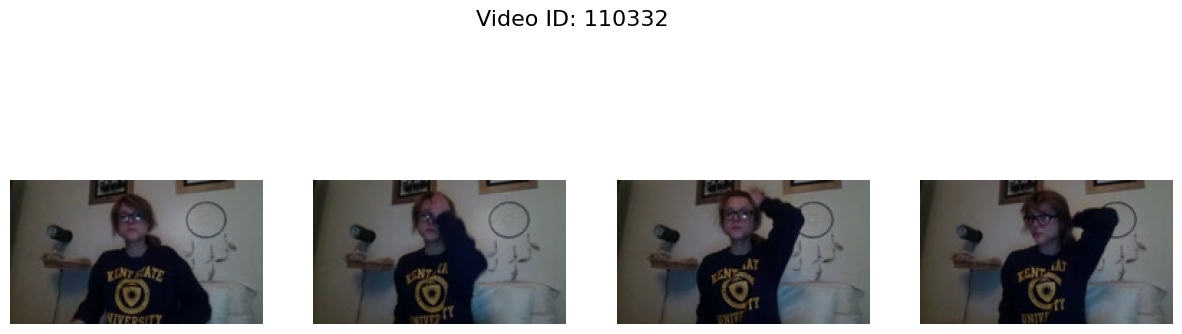

In [17]:
# --- Display the sampled frames ---
# 1. Create a figure with one row and as many columns as the number of sampled frames.
# 2. Loop over axes and frames in parallel, displaying each frame in a separate subplot.
# 3. Turn off axis lines/ticks for a cleaner look.
fig, axes = plt.subplots(1, len(sampled_frames), figsize=(15,5))
for ax, frame in zip(axes, sampled_frames):
    ax.imshow(frame)
    ax.axis('off')

# Add a title showing which video ID we sampled. Then show the figure.
plt.suptitle(f"Video ID: {video_id}", fontsize=16)
plt.show()

### Label Management

Locate the label files(s), parse and check for train/val/test splits.

In [18]:
# Create an empty dictionary to map a specific video ID to its gesture class index.
labels_dict = {}

# Define a lookup table that converts gesture strings (like "Swiping Left") to numeric indices.
gesture_to_index = {
    "Swiping Left": 0,
    "Swiping Right": 1,
    "Swiping Down": 2,
    "Swiping Up": 3,
    "Stop Sign": 4,
    "Thumb Down": 5,
    "Thumb Up": 6,
    "Doing other things": 7,
    "Drumming Fingers": 8,
    "No gesture": 9,
    "Pulling Hand In": 10,
    "Pulling Two Fingers In": 11,
    "Pushing Hand Away": 12,
    "Pushing Two Fingers Away": 13,
    "Rolling Hand Backward": 14,
    "Rolling Hand Forward": 15,
    "Shaking Hand": 16,
    "Sliding Two Fingers Down": 17,
    "Sliding Two Fingers Left": 18,
    "Sliding Two Fingers Right": 19,
    "Sliding Two Fingers Up": 20,
    "Turning Hand Clockwise": 21,
    "Turning Hand Counterclockwise": 22,
    "Zooming In With Full Hand": 23,
    "Zooming In With Two Fingers": 24,
    "Zooming Out With Full Hand": 25,
    "Zooming Out With Two Fingers": 26
}

# Open the CSV file containing training data in read mode.
# Each line in this file presumably includes a video ID and the corresponding gesture label.
with open('/work/jester-v1-train.csv', 'r') as f:
    # Iterate line by line through the file.
    for line in f:
        # Strip whitespace (including newlines) from the current line.
        line = line.strip()
        
        # If the line is empty, skip it (continue to next line).
        if not line:
            continue
        
        # Split the line on the comma, expecting two parts:
        #   vid_id (like "1", "2", or "00001") and gesture_str (like "Swiping Left").
        vid_id, gesture_str = line.split(';')
        
        # Trim extra spaces from each part.
        vid_id = vid_id.strip()      # e.g., "00001"
        gesture_str = gesture_str.strip()  # e.g., "Swiping Left"
        
        # Convert the gesture string to a numeric index via 'gesture_to_index'
        # and store it in 'labels_dict' using the video ID as the key.
        labels_dict[vid_id] = gesture_to_index[gesture_str]


### Check Data Distribution

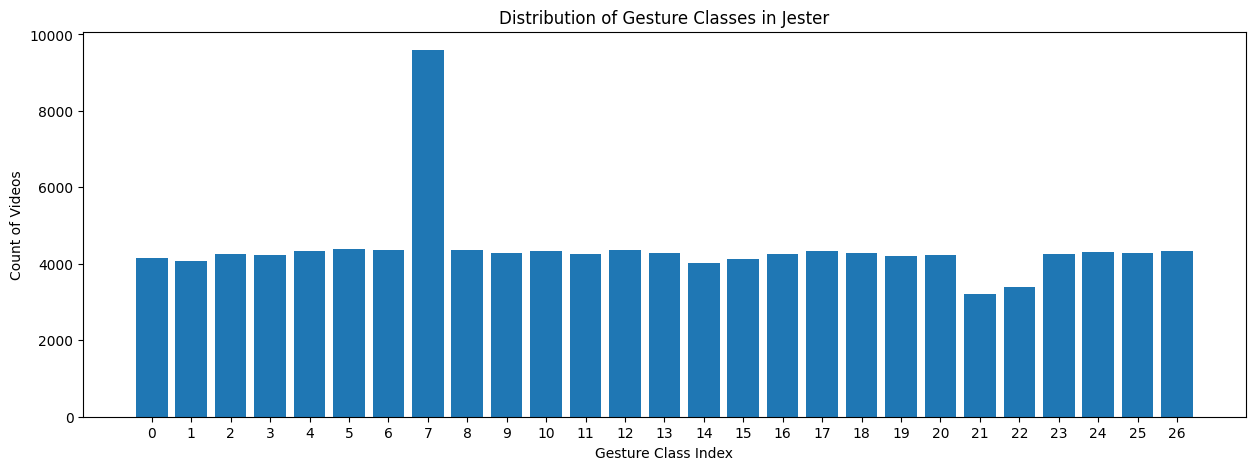

In [19]:
import collections

# Suppose labels_dict is already defined, mapping video IDs to integer class indices
label_counts = collections.Counter(labels_dict.values())

# Sort the keys so we plot them in ascending order
x_indices = sorted(label_counts.keys())

# Extract the corresponding counts in the same order
counts = [label_counts[i] for i in x_indices]

plt.figure(figsize=(15, 5))  # Increase width to 15 inches, height to 5 inches
plt.bar(x_indices, counts)

plt.xlabel("Gesture Class Index")
plt.ylabel("Count of Videos")
plt.title("Distribution of Gesture Classes in Jester")

# Force Matplotlib to use every value in x_indices as a tick
plt.xticks(x_indices)

plt.show()

### Frame Normalization & Resizing

 Basic Resize & Normalize + Preserving Aspect Ratio with Letterboxing

In [20]:
import numpy as np

def preprocess_frame(frame, new_size=(112, 112), mean=(0.45, 0.45, 0.45), std=(0.225, 0.225, 0.225)):
    """
    1. Resizes the frame to new_size (width, height).
    2. Converts pixel values from [0..255] to [0..1].
    3. Normalizes each channel by mean and std (like ImageNet).
    4. Returns the processed frame as a NumPy array in shape (H, W, C).
    """
    # frame is a NumPy array: (H, W, 3) in BGR or RGB
    # 1. Resize
    resized = cv2.resize(frame, new_size, interpolation=cv2.INTER_LINEAR)
    
    # 2. Convert to float32 and scale to [0..1]
    resized = resized.astype(np.float32) / 255.0
    
    # 3. Normalize: (pixel - mean) / std
    # mean and std are tuples for (R, G, B) or (B, G, R), ensure correct channel order
    # If the frame is in RGB, reorder the mean/std accordingly
    for c in range(3):
        resized[..., c] = (resized[..., c] - mean[c]) / std[c]
    
    return resized

# Example usage:
# Suppose 'frame' is a NumPy array loaded by cv2.imread or something similar.
# frame_bgr = cv2.imread("some_frame.jpg")  # shape (H, W, 3) in BGR
# preprocessed = preprocess_frame(frame_bgr, (112, 112))
# print(preprocessed.shape)  # (112, 112, 3)

In [21]:
def resize_with_aspect_ratio(frame, desired_size=(112, 112), padding_color=(0, 0, 0)):
    """
    Resizes 'frame' to fit within desired_size while preserving aspect ratio,
    then pads with 'padding_color' if needed.
    
    frame: NumPy array (H, W, 3)
    desired_size: (desired_width, desired_height)
    padding_color: (B, G, R) or (R, G, B) fill color
    
    Returns: a new NumPy array with shape = desired_size (H, W, 3)
    """
    original_h, original_w = frame.shape[:2]
    desired_w, desired_h = desired_size
    
    # 1. Calculate aspect ratio
    aspect_original = original_w / original_h
    aspect_desired = desired_w / desired_h
    
    # 2. Determine new scaled dimensions
    if aspect_original > aspect_desired:
        # Width is the limiting factor
        new_w = desired_w
        new_h = int(round(new_w / aspect_original))
    else:
        # Height is the limiting factor
        new_h = desired_h
        new_w = int(round(new_h * aspect_original))
    
    # 3. Resize the frame to new_w x new_h
    resized = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # 4. Create an output canvas of desired_size with padding_color
    output = np.full((desired_h, desired_w, 3), padding_color, dtype=resized.dtype)
    
    # 5. Paste the resized image onto the center of the output canvas
    y_offset = (desired_h - new_h) // 2
    x_offset = (desired_w - new_w) // 2
    output[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return output

# Example usage with normalization
def preprocess_frame_aspect(frame, desired_size=(112, 112), mean=(0.45, 0.45, 0.45), std=(0.225, 0.225, 0.225)):
    # 1. Letterbox to preserve aspect ratio
    letterboxed = resize_with_aspect_ratio(frame, desired_size, padding_color=(0,0,0))
    # 2. Convert to float, scale to [0..1]
    letterboxed = letterboxed.astype(np.float32) / 255.0
    # 3. Normalize
    for c in range(3):
        letterboxed[..., c] = (letterboxed[..., c] - mean[c]) / std[c]
    return letterboxed

### Data Loading

Create a pipeline for loading data in batches to reduce memory requirements

In [22]:
from glob import glob

def frames_from_video(video_path, n_frames, output_size=(112, 112)):
    """
    Extract 'n_frames' frames from 'video_path',
    then preprocess each frame and resize it to 'output_size'

    video_path: path to video folder
    n_frames: number of frames to sample
    output_size: size to resize the frames

    Returns: a NumPy array of shape (n_frames, H, W, 3)
    """

    # Get each frame from the video
    frames = glob(video_path + '/*.jpg')

    # Pick 'n_frames' random frames (the frame sampling method can be changed)
    sampled_frames = []
    for i in range(n_frames):
        sampled_frames.append(frames[i * len(frames) // n_frames])

    # Load frames and convert to numpy array
    images = []
    for frame_path in sampled_frames:
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = preprocess_frame(frame, output_size)
        images.append(frame)

    return np.asarray(images)

In [23]:
class FrameGenerator:
    """
    A class that returns a frame generator that yields
    preprocessed frames from a video.

    data: list of video ids and labels
    n_frames: number of frames to sample
    training: whether the FrameGenerator is used for training

    returns: a NumPy array of shape (n_frames, H, W, 3) and the label encoded as an integer
    """
    def __init__(self, data, n_frames, training=False, output_size=(112, 112)):
        self.data = data
        self.n_frames = n_frames
        self.training = training
        self.class_indices = gesture_to_index
        self.output_size = output_size

    def __call__(self):
        if self.training:
            random.shuffle(self.data)

        for video_id, label in self.data:
            frames = frames_from_video(os.path.join(root_dir, video_id), self.n_frames, self.output_size)
            label = self.class_indices[label]
            yield frames, label


In [24]:
# !pip install --upgrade "protobuf==3.20.*"

!pip install protobuf==3.19.6


  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (787 bytes)
Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-spanner 3.49.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
googleapis-common-protos 1.65.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
grpc-google-iam-v1 0.13.1 requires protobuf!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev

In [25]:
!pip install --upgrade "tensorflow==2.11.1"

In [26]:
import tensorflow as tf

# Get a list of video ids and labels
training = []
with open('/work/jester-v1-train.csv', 'r') as f:
    # Iterate line by line through the file.
    for line in f:
        # Strip whitespace (including newlines) from the current line.
        line = line.strip()
        
        # If the line is empty, skip it (continue to next line).
        if not line:
            continue
        
        # Split the line on the comma, expecting two parts:
        #   vid_id (like "1", "2", or "00001") and gesture_str (like "Swiping Left").
        vid_id, gesture_str = line.split(';')
        
        # Add the video id and label to the list.
        training.append((vid_id, gesture_str))

validation = []
with open('/work/jester-v1-validation.csv', 'r') as f:
    # Iterate line by line through the file.
    for line in f:
        # Strip whitespace (including newlines) from the current line.
        line = line.strip()
        
        # If the line is empty, skip it (continue to next line).
        if not line:
            continue
        
        # Split the line on the comma, expecting two parts:
        #   vid_id (like "1", "2", or "00001") and gesture_str (like "Swiping Left").
        vid_id, gesture_str = line.split(';')
        
        # Add the video id and label to the list.
        validation.append((vid_id, gesture_str))


# Create a tensorflow dataset from the list of video ids and labels using the FrameGenerator
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

# NUM_FRAMES = 10
NUM_FRAMES = 20
FRAME_SIZE = (112, 112)

# Trying subset to make things faster
# train_sub = training[:int(len(training) * 0.25)]
train_gen = FrameGenerator(training, n_frames=NUM_FRAMES, training=True, output_size=FRAME_SIZE)
train_ds = tf.data.Dataset.from_generator(train_gen, output_signature=output_signature)

# val_sub = validation[:int(len(validation) * 0.25)]
val_gen = FrameGenerator(validation, n_frames=NUM_FRAMES, training=False, output_size=FRAME_SIZE)
val_ds = tf.data.Dataset.from_generator(val_gen, output_signature=output_signature)

2025-04-03 22:29:51.811372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 22:29:52.409137: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 22:29:54.077678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/venv/lib/python3.10/site-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/loca

### Configure the Dataset for performance

Use buffered prefetching such that we can yield data from the disk without having I/O become blocking.

In [27]:
# Create a dataset pipeline with caching, shuffling, and batching
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 100

# Look further into this part. It was copied directly from the tutorial
# train_ds = train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.shuffle(SHUFFLE_BUFFER_SIZE).prefetch(buffer_size=AUTOTUNE)

# Set the batch size
BATCH_SIZE = 32 # initially 2
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (32, 20, 112, 112, 3)
Shape of training labels: (32,)
Shape of validation set of frames: (32, 20, 112, 112, 3)
Shape of validation labels: (32,)


### Visual Inspection Post-Transformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..2.026144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..2.026144].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..2.026144].
Batch shape: (32, 20, 112, 112, 3)
Labels shape: (32,)
Data type: <dtype: 'float32'>


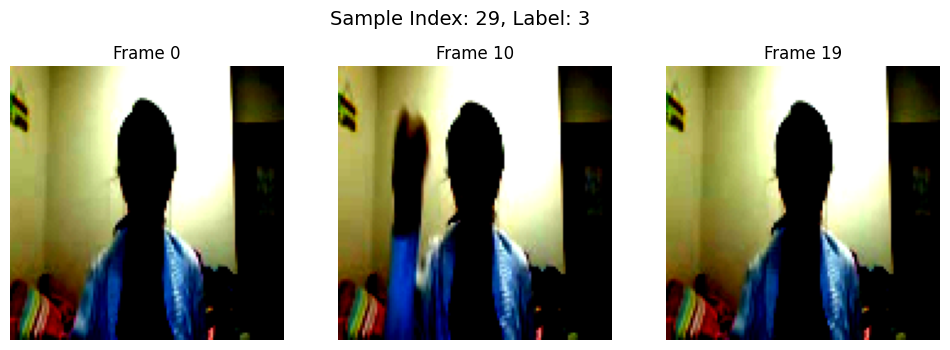

In [28]:
# Fetch a single batch from the dataset
frames_batch, label_batch = next(iter(train_ds))

print("Batch shape:", frames_batch.shape)      # e.g. (B, T, H, W, 3)
print("Labels shape:", label_batch.shape)      # e.g. (B,)
print("Data type:", frames_batch.dtype)        # e.g. tf.float32

# Let's pick a random sample from this batch
batch_size = frames_batch.shape[0]
sample_index = random.randint(0, batch_size - 1)

# frames_batch[sample_index] has shape (T, H, W, 3)
sample_video = frames_batch[sample_index].numpy()

# We'll visualize a few frames from this one video
num_frames = sample_video.shape[0]
frame_indices = [0, num_frames // 2, num_frames - 1]  # first, middle, last

fig, axes = plt.subplots(1, len(frame_indices), figsize=(12, 4))
for ax, f_idx in zip(axes, frame_indices):
    # sample_video[f_idx] is (H, W, 3) in our normalized range
    frame = sample_video[f_idx]

    # Show the frame
    ax.imshow(frame)  
    ax.set_title(f"Frame {f_idx}")
    ax.axis('off')

video_label = label_batch[sample_index].numpy()
plt.suptitle(f"Sample Index: {sample_index}, Label: {video_label}", fontsize=14)
plt.show()

“Clipping input data to the valid range for imshow with RGB data...” simply means frame data includes values outside [0..1]. This happens when we standardize or normalize images (e.g., (pixel - mean)/std can yield negative values or values >1). It’s just a warning that Matplotlib is forcing out-of-range pixels to 0 or 1 for display. This doesn’t affect the model training—it’s only about how the image is rendered on-screen.

### Shape & Data Type Verification

In [29]:
# We have frames_batch, label_batch from the dataset
frames_batch, label_batch = next(iter(train_ds))

print("frames_batch shape:", frames_batch.shape)  
# e.g. (batch_size, num_frames, height, width, 3)

print("frames_batch dtype:", frames_batch.dtype)  
# e.g. tf.float32

# For min/max, convert to NumPy if needed
min_val = frames_batch.numpy().min()
max_val = frames_batch.numpy().max()
print("Pixel value range:", min_val, "to", max_val)

print("label_batch shape:", label_batch.shape)
print("label_batch dtype:", label_batch.dtype)
# Possibly also check label min/max or unique values
unique_labels = np.unique(label_batch.numpy())
print("Unique labels in this batch:", unique_labels)


frames_batch shape: (32, 20, 112, 112, 3)
frames_batch dtype: <dtype: 'float32'>
Pixel value range: -2.0 to 2.4444447
label_batch shape: (32,)
label_batch dtype: <dtype: 'int16'>
Unique labels in this batch: [ 2  3  4  5  6  7  8  9 10 11 12 16 17 18 21 22 23]


frames_batch shape: (2, 10, 112, 112, 3) → We have 2 videos in the batch, each with 10 frames at 112×112×3.

dtype: float32 is standard for deep learning pipelines.

Label batch shape (2,) is expected for 2 samples, and int16 is fine (though int32 or int64 is also common).

Pixel Value Range: -2.0 to 2.4444447
- Indicates we’re applying (pixel - mean)/std with mean ~ 0.45 and std ~ 0.225. That’s perfectly normal — negative values occur if (pixel < mean), and values >1 occur if (pixel > mean + std).
- If we want to see “true color” images, we’d have to denormalize them before displaying (i.e., do (img * std) + mean and clamp to [0,1]).
Labels: [5 15]
- Means the two videos in this batch correspond to gesture indices 5 and 15. We can look up the gesture_to_index dict to confirm which gestures those are.

## Feature Extraction and Model Training (3D CNN)



Treat each video clip as a 3D volume (Time × Height × Width). Convolutional filters operate in 3D, capturing both spatial and temporal information in a single pass.

Why It’s Good: 3D convolutions natively handle spatiotemporal data, often achieving strong accuracy on gesture/action recognition tasks. If we keep the channel widths modest (fewer feature maps), it can run in real-time on 112×112 inputs.

SHOULD ANSWER WHY NOT OTHER MODELS/MODEL COMBINATIONS

### Defining the Model

In [30]:
# def build_3d_cnn(num_classes=27, input_shape=(10, 112, 112, 3)):
#     """
#     Builds a small 3D CNN for spatiotemporal feature extraction and classification.
    
#     Arguments:
#       num_classes: Number of gesture classes to predict.
#       input_shape: (T, H, W, C), e.g. (10, 112, 112, 3)
    
#     Returns:
#       model: A Keras Model object.
#     """
#     # Define the input layer. 
#     # The batch dimension is omitted; Keras will handle it automatically.
#     inputs = tf.keras.Input(shape=input_shape)
    
#     # --- 3D Convolution Block 1 ---
#     # Convolution in (time, height, width) with 32 filters.
#     x = tf.keras.layers.Conv3D(
#         filters=32, kernel_size=(3,3,3), 
#         strides=(1,1,1), padding='same', activation='relu'
#     )(inputs)
#     # Reduce spatial dimension with MaxPooling. 
#     # pool_size=(1,2,2) means we only downsample in height/width, not in time.
#     x = tf.keras.layers.MaxPool3D(pool_size=(1,2,2))(x)
    
#     # --- 3D Convolution Block 2 ---
#     x = tf.keras.layers.Conv3D(
#         filters=64, kernel_size=(3,3,3), 
#         strides=(1,1,1), padding='same', activation='relu'
#     )(x)
#     # This time, we pool in all dimensions, including time, to reduce temporal length.
#     x = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(x)
    
#     # --- 3D Convolution Block 3 ---
#     x = tf.keras.layers.Conv3D(
#         filters=128, kernel_size=(3,3,3), 
#         strides=(1,1,1), padding='same', activation='relu'
#     )(x)
#     # Instead of another pooling, we can apply a global average pool 
#     # to collapse all remaining spatial/time dims into one vector.
#     x = tf.keras.layers.GlobalAveragePooling3D()(x)
    
#     # --- Fully Connected Layers ---
#     # A dense layer for further feature processing.
#     x = tf.keras.layers.Dense(256, activation='relu')(x)
#     x = tf.keras.layers.Dropout(0.3)(x)  # 30% dropout for regularization
    
#     # Output layer: num_classes gestures with softmax.
#     outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
#     # Build the model.
#     model = tf.keras.Model(inputs, outputs, name="3D_CNN_Gesture")
#     return model

Input Shape: (T,H,W,C) = (10,112,112,3). Keras expects this in the input_shape (excluding batch size).

Conv3D Layers:
- We apply 3D convolutions to learn both spatial and temporal features.
- The first MaxPool only downsamples spatial dims, the second also downsamples the temporal dimension (time).

GlobalAveragePooling3D:
- Collapses any remaining spatiotemporal dimensions into a single vector.
- Simpler than multiple pooling blocks; helps keep the model small.

Dense Layers:
- We add a hidden Dense layer (256 units) with dropout to reduce overfitting.
- The final Dense layer has num_classes units with softmax for classification.


Using Keras Tuner to search for optimal hyperparameters for the 3D CNN. This code defines a hypermodel function that builds and compiles a 3D CNN, sets up a RandomSearch tuner, and then runs the search on the training and validation datasets.

In [31]:
!pip install keras_tuner==1.4.7

In [32]:
import keras_tuner as kt  # Import Keras Tuner
import numpy as np

# Define a function that builds and compiles a 3D CNN model given hyperparameters.
def build_model(hp):
    """
    Builds a 3D CNN model with hyperparameters to tune.
    
    Hyperparameters tuned:
    - Number of filters in the first Conv3D layer (16 to 64)
    - Dropout rate after the Dense layer (0.2 to 0.5)
    - Learning rate for the Adam optimizer (1e-4 to 1e-2)
    
    The model input shape is (T, H, W, C) = (10, 112, 112, 3).
    """
    inputs = tf.keras.Input(shape=(20, 112, 112, 3)) # initially (10, 112, 112, 3)
    
    # Tune number of filters in the first 3D convolution block
    filters1 = hp.Int('filters1', min_value=16, max_value=64, step=16)
    x = tf.keras.layers.Conv3D(filters=filters1, kernel_size=(3,3,3),
                               strides=(1,1,1), padding='same', activation='relu')(inputs)
    # Pool spatial dimensions only
    x = tf.keras.layers.MaxPool3D(pool_size=(1,2,2))(x)
    
    # Second 3D Conv block (fixed parameters for simplicity)
    x = tf.keras.layers.Conv3D(filters=64, kernel_size=(3,3,3),
                               strides=(1,1,1), padding='same', activation='relu')(x)
    # Pool in all dimensions CT
    x = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(x)
    
    # Third 3D Conv block
    x = tf.keras.layers.Conv3D(filters=128, kernel_size=(3,3,3),
                               strides=(1,1,1), padding='same', activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    
    # Fully Connected Layers
    embedding_layer = tf.keras.layers.Dense(256, activation='relu', name="embedding_layer")(x)
    # Tune dropout rate between 0.2 and 0.5
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(embedding_layer)
    
    outputs = tf.keras.layers.Dense(27, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs, name="3D_CNN_Gesture")
    
    # Tune learning rate for the Adam optimizer.
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

build_model(hp):
This function uses the HyperParameters (hp) object to specify tunable parameters such as the number of filters in the first convolutional layer (filters1), the dropout rate (dropout_rate), and the learning rate for the optimizer (learning_rate).

The architecture consists of three 3D convolution blocks, a global average pooling layer, and fully connected layers. The output layer uses softmax for 27 gesture classes.

In [33]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.11.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Training the 3D CNN

Below is the training procedure using model.fit on the train_ds and val_ds we created. 

Each element of train_ds is (frames batch,label batch).
frames_batch.shape = (B, T, 112, 112, 3) and label_batch.shape = (B,).
We have 27 classes in total.

In [34]:
# # Create the model
# model_3d = build_3d_cnn(num_classes=27, input_shape=(10, 112, 112, 3))

# # Compile the model
# model_3d.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )

# # Train the model
# EPOCHS = 20  # adjust as needed
# history = model_3d.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds
# )


Compile:
- Optimizer: Adam with a moderate learning rate (e.g., 1e-3).
- Loss: SparseCategoricalCrossentropy, since our labels are integer-encoded.
- Metrics: accuracy is standard for classification.

Fit:
- We specify epochs=5 for a quick test. We might need 20+ epochs for better performance.
- The model reads batches from train_ds (and uses val_ds for validation).


In [35]:
# Set up the Keras Tuner: We'll use RandomSearch for this.
tuner = kt.RandomSearch(
    build_model,                        # Our hypermodel function.
    objective='val_accuracy',           # We want to maximize validation accuracy.
    max_trials=3,                      # Try 3 different hyperparameter combinations. Initially tried 10, but it took too long.
    executions_per_trial=1,             # Each combination is evaluated once.
    directory='hyper_tuning',           # Directory to save tuning results.
    project_name='gesture_recognition'  # A subfolder name for our project.
)

# Display a summary of the search space.
tuner.search_space_summary()

Reloading Tuner from hyper_tuning/gesture_recognition/tuner0.json
Search space summary
Default search space size: 3
filters1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Setting Up the Tuner:
We instantiate a RandomSearch tuner from Keras Tuner that explores 3 different hyperparameter combinations. 
Initially tried 10 combinations, but it took too long.

The tuner is set to optimize the validation accuracy (val_accuracy).

tuner.search:
This runs the hyperparameter search over the specified number of epochs (20 in this example) and uses an EarlyStopping callback to stop training early if the validation loss does not improve for 3 consecutive epochs.

In [36]:
# Now, run the hyperparameter search.

EPOCHS = 20

tuner.search(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# After the search completes, print a summary of the results.
tuner.results_summary()

Results summary
Results in hyper_tuning/gesture_recognition
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
filters1: 16
dropout_rate: 0.30000000000000004
learning_rate: 0.0012998763075827591
Score: 0.6329208016395569

Trial 00 summary
Hyperparameters:
filters1: 48
dropout_rate: 0.4
learning_rate: 0.00013499193296499687
Score: 0.5792250037193298

Trial 01 summary
Hyperparameters:
filters1: 48
dropout_rate: 0.2
learning_rate: 0.003225943238477045
Score: 0.09927639365196228


Results and Best Model:
After the search, we print a summary of the best hyperparameters and then build and train the best model fully.

In [37]:
# Get the best hyperparameters.
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"Filters in first Conv3D: {best_hp.get('filters1')}")
print(f"Dropout rate: {best_hp.get('dropout_rate')}")
print(f"Learning rate: {best_hp.get('learning_rate')}")

# Finally, build the best model and train it fully.
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Best hyperparameters:
Filters in first Conv3D: 16
Dropout rate: 0.30000000000000004
Learning rate: 0.0012998763075827591
Epoch 1/20
2025-04-03 22:30:21.692151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204
2025-04-03 22:30:29.651343: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5fd96bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-03 22:30:29.651365: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-03 22:30:29.729377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-03 22:30:30.470696: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
3706/3706 [==============================] - 2912s 781ms/

### Monitoring Performance

During training, Keras prints the loss and accuracy for both the training and validation sets for each epoch. 

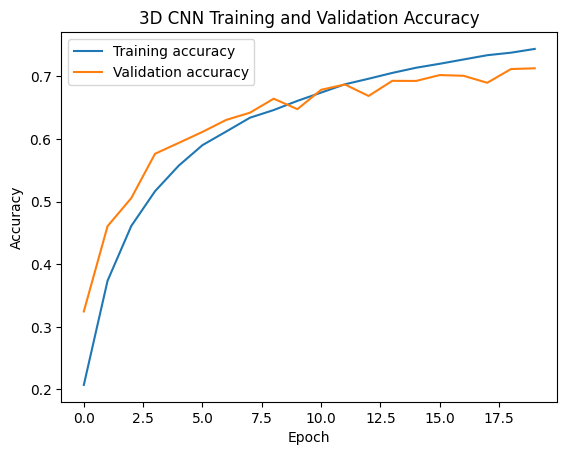

In [38]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("3D CNN Training and Validation Accuracy")
plt.show()

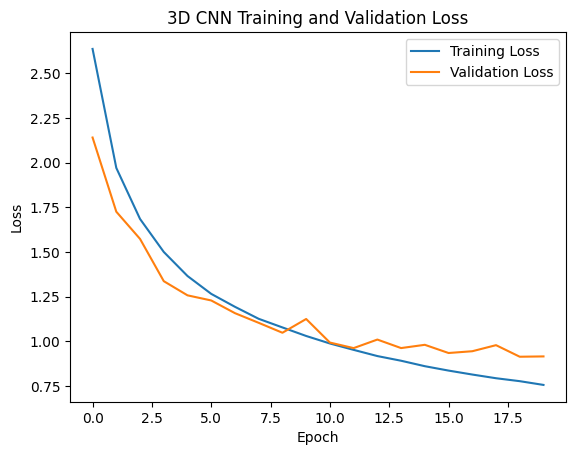

In [39]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("3D CNN Training and Validation Loss")
plt.show()

### Final Inference and Evaluation

In [40]:
# Evaluate on the validation set
val_loss, val_acc = best_model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}), Validation Acuracy: {val_acc:.2%}")

463/463 [==============================] - 270s 579ms/step - loss: 0.9159 - accuracy: 0.7129
Validation Loss: 0.9159), Validation Acuracy: 71.29%


Next steps:

Evaluate on test set as well! Need to consider other evaluation metrics as well.
We can keep the architecture light (fewer filters, fewer frames) to maintain high FPS.
-Use fewer filters per layer (e.g., 32 → 64 → 128) to reduce computational load.
-Limit the number of frames (e.g., 8 or 16 frames per clip) to maintain real-time performance.
-If we want even more efficiency, explore depthwise or group convolutions (like in MobileNet or ShuffleNet), but custom-tailored for 112×112.

Most likely have to do model quantization to run on embedded device
Can set batch size = 1 if doing single real-time single video classification

Tried:
- using all of the data
- increasing epochs to 20
- increased number of frames to 20
- using GPU and setting batch size = 32 (for faster processing)

Training and validation accuracy improved significantly to ~69%.

Then did hyperparameter search to find the best hyperparameters, which resulted in 74% training accuracy, but still 69% validation accuracy the first time. Then 71% validation accuracy the second time.

On validation data, compute confusion matrix, F1-scores, etc., for deeper insight beyond raw accuracy.

In [41]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 169.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 268.7 MB/s eta 0:00:00


1/1 [==============================] - 0s 188ms/step
Confusion Matrix:
 [[ 422   23    4    3    1    2    0    9    0    0    3    1    0    1
     3    1    0    2   15    1    0    0    2    1    0    0    0]
 [  85  331    4    2    0    1    0   14    0    3    8    2    1    0
     2    1    1    3    2   21    0    3    2    0    0    0    0]
 [   2    0  382   16    5    3    0   14    2    2   23    6    7    1
     7    4    3   20    1    0    6    1    0    3    0   12    0]
 [   5    0   24  338    0    5    0    7    4    0   79    4    2    1
     0    3    0    5    0    1   20    2    1    4    0    2    1]
 [   5    0   17   11  347    1    0   17    1    7    9    6   70    3
     0    0   11    0    0    0    1    3    4   13    0    8    2]
 [   1    0    4    1    0  458    1   56    0    4    1    0    0    0
     2    3    0    0    0    0    0    0    0    0    0    4    1]
 [   0    0    1    5    2    2  421   31    2    3    2   15    2   18
     0    0    0

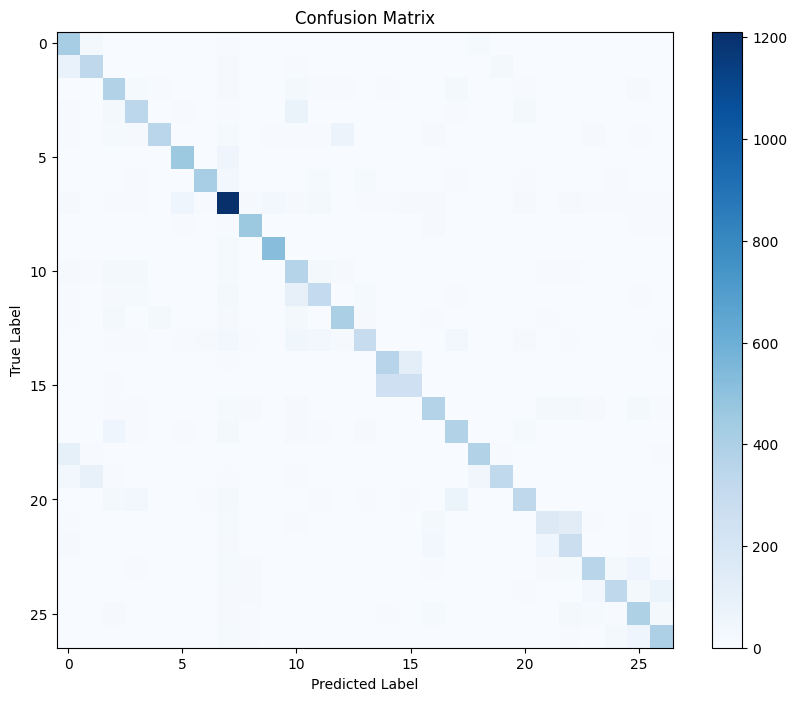

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Collect predictions and true labels from the validation set
all_preds = []
all_labels = []

for frames_batch, label_batch in val_ds:
    preds = best_model.predict(frames_batch)  # shape (B, num_classes)
    pred_classes = np.argmax(preds, axis=1)
    all_preds.extend(pred_classes)
    all_labels.extend(label_batch.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(27))  # 27 classes
print("Confusion Matrix:\n", cm)

# Classification Report (F1, precision, recall)
report = classification_report(all_labels, all_preds, labels=range(27))
print("Classification Report:\n", report)

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Overall weighted accuracy: ~71% is pretty solid, especially for a 27-class problem, which is inherently challenging.

High-performing classes (F1 > 0.75):
5, 6, 7, 8, 9, 12, 18 → These likely have consistent and distinguishable gestures.

Low-performing classes (F1 < 0.6):
10, 13, 14, 15, 21, 22 → These might have similar gestures or noisy data.

Class imbalance is not severe based on support counts, so class performance gaps are more likely due to inter-class similarity, poor lighting, occlusions, or user variation.

Misclassifications between adjacent classes (like 10, 13, 14, etc.) could indicate that the model struggles with subtle variations.

The core diagonal is strong, showing the model has learned the majority of gestures well.

Classes like:

Thumb Up (6)

Stop Sign (4)

Thumb Down (5)

Drumming Fingers (8)
seem to have very high precision and are rarely misclassified.

Inference: Gestures with distinct hand postures and minimal movement (static gestures) are more robustly learned.

----------------------------------------------------------------------------------------------------------------------

The diagonal dominance is strong, which is a good sign — it means most predictions are correct.

However, there are some notable off-diagonal elements (faint but visible), indicating consistent misclassifications between specific gesture pairs.

Directionally Similar Gestures:
Swiping Left (0) ↔ Swiping Right (1)

Sliding Two Fingers Left (18) ↔ Right (19) or Down (17)

Turning Hand Clockwise (21) ↔ Counterclockwise (22)

Reason: These gestures likely share similar frames except for motion direction, which static CNNs may not encode well.

--------------------------------------------------------

One-Hand vs. Two-Finger Gestures:
Pushing Hand Away (12) ↔ Pushing Two Fingers Away (13)

Zooming In with Full Hand (23) ↔ with Two Fingers (24)

Zooming Out Full (25) ↔ Two Fingers (26)

Reason: Spatial footprint is similar, especially in low-resolution or blurred frames — hard for the model to pick up the difference without explicit focus mechanisms.

--------------------------------------------------------

Ambiguous or Noisy Gestures:
"No Gesture" (9) and "Doing Other Things" (7) seem to be involved in some dispersion across multiple classes.

Reason: These are inherently fuzzy classes and often leak into others if the user makes partial gestures or background motion.

--------------------------------------------------------

Gestures With Lower F1 Scores from Before:
From the classification report, we saw:

Pulling Hand In (10), Rolling Backward (14), Forward (15), Clockwise (21) — these showed lower recall or precision, which matches their mild misclassification footprints here.

### Evaluating on Test Data 

The test dataset file only contains video IDs (with no corresponding gesture labels), it means the test set is unlabeled— we can run inference to get predictions, but we cannot directly compute accuracy (or any other supervised metric).

In [43]:
test_data = []
with open('/work/jester-v1-test.csv', 'r') as f:
    for line in f:
        vid_id = line.strip()
        if vid_id:
            # label = None, so we skip dictionary lookups
            test_data.append((vid_id, None))

The existing FrameGenerator likely expects (vid_id, label) for each entry. If it tries to map label = self.class_indices[label], we’ll get an error because None or 0 won’t match a dictionary of gesture strings.

In [44]:
# def __call__(self):
#     if self.training:
#         random.shuffle(self.data)

#     for video_id, label in self.data:
#         frames = frames_from_video(os.path.join(root_dir, video_id),
#                                    self.n_frames, self.output_size)

#         # If label is None (unlabeled test data), skip dictionary lookup
#         if label is None:
#             yield frames, -1
#         else:
#             mapped_label = self.class_indices[label]
#             yield frames, mapped_label


In [45]:
class TestFrameGenerator:
    """
    Similar to FrameGenerator, but for unlabeled data (test).
    Yields (frames, None).
    """
    def __init__(self, data, n_frames=20, output_size=(112, 112)):
        self.data = data
        self.n_frames = n_frames
        self.output_size = output_size

    def __call__(self):
        for video_id, _ in self.data:
            frames = frames_from_video(os.path.join(root_dir, video_id),
                                       self.n_frames, self.output_size)
            yield frames, None  # no label


In [46]:
# class FrameGenerator:
#     def __init__(self, data, n_frames, training=False, output_size=(112, 112)):
#         self.data = data
#         self.n_frames = n_frames
#         self.training = training
#         self.class_indices = gesture_to_index
#         self.output_size = output_size

#     def __call__(self):
#         if self.training:
#             random.shuffle(self.data)

#         for video_id, label in self.data:
#             frames = frames_from_video(os.path.join(root_dir, video_id),
#                                        self.n_frames, self.output_size)
#             # If label is None, skip dictionary lookup:
#             if label is None:
#                 yield frames, -1  # or some dummy label
#             else:
#                 mapped_label = self.class_indices[label]
#                 yield frames, mapped_label

In [47]:
# test_data = []
# with open('jester-v1-test.csv', 'r') as f:
#     for line in f:
#         vid_id = line.strip()
#         test_data.append((vid_id, None))  # label is None

# test_gen = FrameGenerator(test_data, n_frames=NUM_FRAMES, training=False, output_size=(112, 112))

# output_signature = (
#     tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
#     tf.TensorSpec(shape=(), dtype=tf.int16)
# )
# test_ds = tf.data.Dataset.from_generator(test_gen, output_signature=output_signature)
# test_ds = test_ds.batch(32)

# predictions = model_3d.predict(test_ds)
# pred_classes = np.argmax(predictions, axis=1)


In [48]:
# test_gen = FrameGenerator(
#     data=test_data,
#     n_frames=NUM_FRAMES,
#     training=False,
#     output_size=(112, 112)  # same as train
# )

# # The output signature might expect an int label, so pass a placeholder.
# output_signature = (
#     tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
#     tf.TensorSpec(shape=(), dtype=tf.int16)
# )

# test_ds = tf.data.Dataset.from_generator(test_gen, output_signature=output_signature)
# test_ds = test_ds.batch(BATCH_SIZE)

# predictions = model_3d.predict(test_ds)
# # predictions: shape (num_videos, num_classes)
# predicted_classes = np.argmax(predictions, axis=1)

predicted_classes is a NumPy array of integer class IDs for each video in the test set, in the same order we read them. We can save the predictions to a CSV file.

In [49]:
output_signature_test = (
    tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.float32)  # or tf.int16, but label is dummy
)

test_gen = TestFrameGenerator(test_data, n_frames=20, output_size=(112, 112))
test_ds = tf.data.Dataset.from_generator(test_gen, output_signature=output_signature_test)
test_ds = test_ds.batch(32)

predictions = best_model.predict(test_ds)
pred_classes = np.argmax(predictions, axis=1)


461/461 [==============================] - 325s 705ms/step


In [50]:
# import csv

# with open('/work/test_predictions.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['video_id', 'predicted_class'])
#     for (vid_id, _), cls_idx in zip(test_data, predicted_classes):
#         writer.writerow([vid_id, cls_idx])

This gives us a CSV mapping each test video ID to the predicted gesture class index.

In [51]:
# !cat test_predictions.csv

Using unsupervised learning

Extracting Embeddings:
We create an embedding_model that takes the same input as the trained model but outputs the activations from the "embedding_layer" (the 256-unit Dense layer). This produces a fixed-length feature vector for each video clip.

KMeans Clustering:
The extracted embeddings are then fed into a KMeans clustering algorithm. Here, we set n_clusters=27 (one for each gesture class), which helps us see if the embeddings naturally group into distinct clusters corresponding to the gestures.

PCA Visualization:
Since the embeddings are 256-dimensional, we use PCA to reduce them to 2 dimensions for visualization. The scatter plot shows how the videos cluster in this reduced space, with colors representing the cluster assignments from KMeans.

This code helps us assess whether the intermediate features learned by the 3D CNN capture meaningful differences between gestures. If the clusters correspond well to known gesture categories, it’s a good sign that our feature extractor is effective.

In [52]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Extract Intermediate Embeddings
# Create a new model that outputs the intermediate embeddings
# from the penultimate layer. We assume that in build_3d_cnn, the 
# Dense layer producing the 256-dimensional vector was named 'embedding_layer'.
embedding_model = tf.keras.Model(
    inputs=best_model.input, 
    outputs=best_model.get_layer('embedding_layer').output
)

# Now, use this model to get embeddings for each test video.
# Here, test_ds is the test dataset (with unlabeled data) batched appropriately.
embeddings = embedding_model.predict(test_ds)
print("Embeddings shape:", embeddings.shape)
# This should print a shape of (N, 256), where N is the number of test samples.

461/461 [==============================] - 263s 571ms/step
Embeddings shape: (14743, 256)


In [53]:
# Perform KMeans Clustering on the Embeddings
# We choose the number of clusters. In this example, we set it to 27,
# corresponding to the 27 gesture classes. (Can experiment with other values.)
n_clusters = 27
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_
print("Cluster labels assigned by KMeans:", cluster_labels)

Cluster labels assigned by KMeans: [21 11  3 ... 16  3  2]


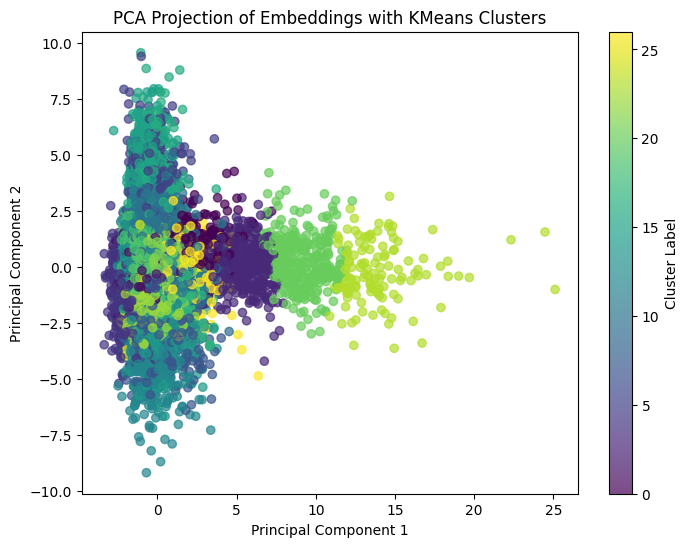

In [54]:
# Visualize the Clusters Using PCA
# We reduce the embedding dimensions from 256 to 2 using PCA for visualization.
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create a scatter plot of the 2D embeddings, colored by their cluster labels.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title("PCA Projection of Embeddings with KMeans Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Cluster Label")
plt.show()

There’s a dense core cluster (label 0 dominates the center), likely due to KMeans assigning many similar or overlapping points to one cluster.

Some clusters are tightly formed, others are diffuse, indicating varying intra-cluster compactness.

There’s a clear directionality in variance (x-axis from ~0 to 25), meaning most discriminative variance lies in that component.

The cluster labeled 0 appears to dominate in volume — KMeans often dumps unstructured data into one big cluster when the separation isn’t strong.

Some gesture types may not be easily separable in the latent space — suggesting the embeddings might not be very well structured.

----------------------------------------------------------------------

A large number of points are labeled with cluster 0, densely packed in the center.

Likely candidates for this "Cluster 0":
"Doing other things" (7)

"No gesture" (9)

These are catch-all or non-specific gestures, which likely:

Share overlapping features with multiple other gestures.

Have high intra-class variation (especially "doing other things").

Are hard for KMeans to separate cleanly due to lack of consistent spatial/temporal features.

Inference: The model might be encoding "neutral" gestures in a very centralized embedding space, which is common in latent space learning.

----------------------------------------------------------------------

Gestures like:

"Swiping Left" (0) vs. "Swiping Right" (1)

"Sliding Two Fingers Left" (18) vs. "...Right" (19)

"Zooming In" (23/24) vs. "Zooming Out" (25/26)

"Rolling Hand Backward" (14) vs. "Forward" (15)

"Turning Hand Clockwise" (21) vs. "Counterclockwise" (22)

These pairs likely generate similar visual embeddings (e.g., direction of motion or finger configuration), with only subtle temporal/spatial differences.

Inference: These classes may have been:

Clustered close to each other (neighboring points on the PCA map).

Even assigned to the same KMeans cluster, if the separation is subtle and PCA failed to retain directional nuance.

----------------------------------------------------------------------

Gestures like:

"Stop Sign" (4)

"Thumb Up" (6) / "Thumb Down" (5)

"Drumming Fingers" (8)

"Zooming In/Out with Full Hand" (23/25)

These have unique hand shapes or motions, and are likely:

Easier to distinguish, forming clearer PCA clusters.

Possibly grouped further from the dense core.

Inference: These might correspond to well-separated clusters in the PCA-KMeans plot. The model likely learned discriminative features for them.

----------------------------------------------------------------------

Based on F1 scores and semantics, some confusing gesture pairs might be:

"Pulling Hand In" (10) vs. "Pushing Hand Away" (12)

"Rolling Hand Backward" (14) vs. "Forward" (15)

"Zooming with Full Hand" vs. "Zooming with Two Fingers"

"Turning Hand Clockwise" (21) vs. "Sliding Two Fingers Right" (19)

These can be visually/temporally similar depending on:

Camera angle

Lighting

User variability

Inference: Such pairs likely end up in adjacent clusters or even overlap, indicating embedding space confusion.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4a661b14-a932-49f0-82f9-7865e07a1069' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>